In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Best reg_param for amgut2 FoldID:1 is 0.4954999999999999
Best no of edges for amgut2 FoldID:1 is 785.0


/tmp/ipykernel_2564320/3850997681.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


Best reg_param for amgut2 FoldID:1 is 0.4479999999999999
Best no of edges for amgut2 FoldID:1 is 1231.0


/tmp/ipykernel_2564320/3850997681.py:95: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


Best reg_param for amgut2 FoldID:1 is -1.1279591836734693
Best no of edges for amgut2 FoldID:1 is 1585


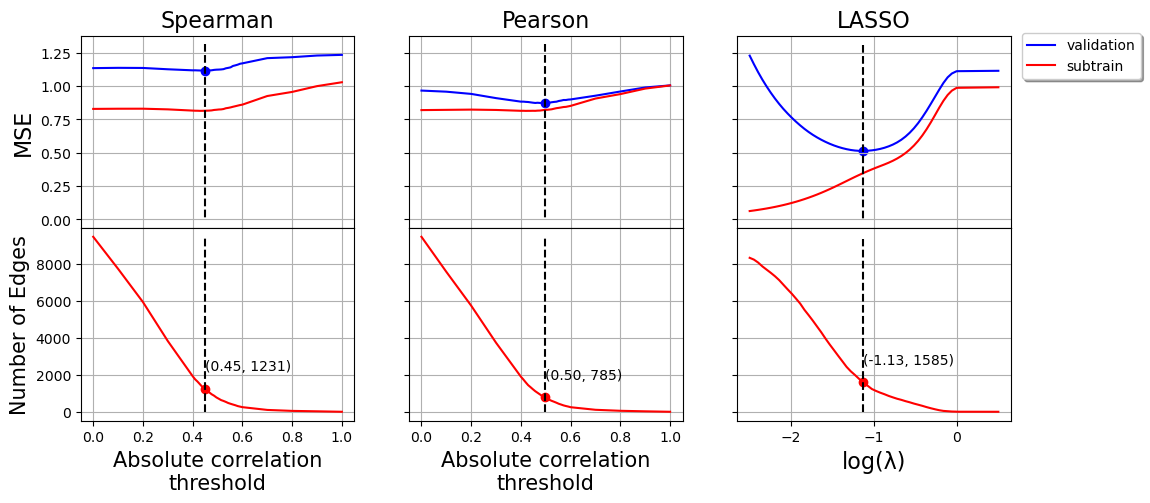

In [15]:
date_time = "2023-06-01_14:32" # amgut2
# date_time = "2023-06-01_15:06" # crohns
# date_time = "2023-06-01_15:12" # ioral
# date_time = "2023-06-21_20:44" # necromass_bacteria

root_dir = "/projects/genomic-ml/da2343/ml_project_1/model_complexity/pearson_corr"
source_target_dir = "/projects/genomic-ml/da2343/ml_project_1/model_complexity/source_target"
model_complexity_df = pd.read_csv(f"{root_dir}/pearson_corr_{date_time}.csv")



algorithm_list = model_complexity_df["algorithm"].unique()
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.7))
# create with two rows and three columns
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 5), sharey='row', sharex='col')
# plt.rcParams.update({'font.size': 20})

for algorithm in algorithm_list:
    filtered_algorithm_df = model_complexity_df[model_complexity_df["algorithm"] == algorithm]
    # Get unique values as list from column name `Dataset`
    dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
    for dataset in dataset_list:
        # Get new dataframe with only the dataset
        sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
        fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
        
        filtered_fold_id_df_list = []
           
        # make a plot of the mean train score and mean test score for each reg_param
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.5))
        # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 2.7))
            
        for fold_id  in fold_id_list :
            test_error_df_list = []
            filtered_fold_id_df = sub_dataset_df[sub_dataset_df["fold_id"] == fold_id]
            
            reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
            for reg_param in reg_param_list:
                filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                subtrain_score = filtered_reg_param['subtrain_score'].mean()
                validation_score = filtered_reg_param['validation_score'].mean()
                edges = filtered_reg_param['edges'].mean()
        
                test_error_dict = {
                    'fold_id': fold_id,
                    'subtrain' :  subtrain_score,
                    'validation' : validation_score,
                    'data_set_name': dataset,
                    'reg_param': reg_param,
                    'algorithm' : algorithm,
                    'edges': edges
                }
                test_error_df_list.append(pd.DataFrame(test_error_dict, index=[0]))
            test_err_df = pd.concat(test_error_df_list).reset_index()
            
            if (algorithm == "Spearman") and fold_id == 1:
                ax_top = ax1
                ax_bottom = ax4
            elif (algorithm == "Pearson") and fold_id == 1:
                ax_top = ax2
                ax_bottom = ax5
            else:
                continue
    
            
            test_err_df.plot( x="reg_param", 
                              y=['validation', 'subtrain'], 
                              ax=ax_top,
                              title=f'{algorithm}',
                              xlabel='', 
                              ylabel='Mean Squared Error', color = ['blue', 'red'], 
                              grid=True, 
                              legend=False,
                              )
            # ax_top.legend(loc='lower right', prop={'size': 8.1})
            ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            test_err_df.plot(x="reg_param", y= 'edges', ax=ax_bottom,
                              xlabel='Absolute correlation threshold', 
                              ylabel='Number of Edges',
                              color = ['red'], 
                              legend=False,
                              grid=True
                              )
            # ax_bottom.set_yticks([785, 5000, 9000])
            best_reg_param = test_err_df.loc[test_err_df['validation'].idxmin()]['reg_param']
            best_validation = test_err_df.loc[test_err_df['validation'].idxmin()]['validation']
            best_edges = test_err_df.loc[test_err_df['validation'].idxmin()]['edges']
            
            print(f"Best reg_param for {dataset} FoldID:{fold_id} is {best_reg_param}")
            print(f"Best no of edges for {dataset} FoldID:{fold_id} is {best_edges}")
            
            source_target_df = pd.read_csv(f"{source_target_dir}/source_target_{date_time}.csv")
            filtered_source_target_df = source_target_df[(source_target_df["data_set_name"] == dataset) & (source_target_df["fold_id"] == fold_id) & (source_target_df["algorithm"] == algorithm) & (abs(source_target_df["weight"]) > best_reg_param)]
            filtered_source_target_df = filtered_source_target_df.groupby(["source", "target"]).mean().reset_index()
            filtered_fold_id_df_list.append(filtered_source_target_df)
            

            ax_top.scatter(best_reg_param, best_validation, color='blue')
            ax_bottom.scatter(best_reg_param, best_edges, color='red')
            # Write (x,y) coordinates of the best reg_param and best validation score on the bottom plot
            ax_bottom.annotate(f'({best_reg_param:.2f}, {best_edges:.0f})', xy=(best_reg_param, best_edges), xytext=(best_reg_param, best_edges + 1000))
            
            ax_top.plot([best_reg_param, best_reg_param], 
                        np.array([np.min(test_err_df['subtrain']) + 0.5, 
                                  0  ]), 
                        'k--')
            ax_bottom.plot([best_reg_param, best_reg_param], 
                           np.array([np.min(test_err_df['edges']), 
                                     np.max(test_err_df['edges'])]), 'k--')
            # plt.plot(line_x, line_y, color='black', linestyle='--')
            
            # Set the font size of the xlabel and ylabel to 14
            ax_top.set_ylabel('MSE', fontsize=16)
            ax_top.set_title(f'{algorithm}', fontsize=16)
            ax_bottom.set_xlabel('Absolute correlation\nthreshold', fontsize=15)
            ax_bottom.set_ylabel('Number of Edges', fontsize=15)
            
            
    
        source_target_df = pd.concat(filtered_fold_id_df_list)
        source_target_df = source_target_df.groupby(["source", "target"]).median().reset_index()
        # source_target_df.to_csv(f"/home/da2343/cs685_fall22/model_complexity/source_target/{dataset}_{algorithm}_source_target.csv", index=False)




root_dir = "/projects/genomic-ml/da2343/ml_project_1/model_complexity/lasso_coef"
model_complexity_df = pd.read_csv(f"{root_dir}/lasso_coef_2023-06-01_14:32.csv")
algorithm_list = model_complexity_df["algorithm"].unique()
for algorithm in algorithm_list:
    filtered_algorithm_df = model_complexity_df[model_complexity_df["algorithm"] == algorithm]
    dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
    for dataset in dataset_list:
        sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
        fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
        for fold_id  in fold_id_list :
            if (algorithm == "LASSO") and fold_id == 1:
                ax_top = ax3
                ax_bottom = ax6
            else:
                continue
            test_error_df_list = []
            filtered_fold_id_df = sub_dataset_df[sub_dataset_df["fold_id"] == fold_id]
            reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
            for reg_param in reg_param_list:
                filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                subtrain_score = filtered_reg_param['subtrain_score'].mean()
                validation_score = filtered_reg_param['validation_score'].mean()
                edges = 0
                index_of_pred_col_list = sorted(filtered_reg_param["index_of_pred_col"].unique().tolist())
                coef_matrix_list = []
                for index_of_pred_col in index_of_pred_col_list:
                    filtered_index_of_pred = filtered_reg_param[filtered_reg_param['index_of_pred_col'] == index_of_pred_col]
                    coefs = filtered_index_of_pred['coefs'].values.tolist()
                    coefs_str =  coefs[0]
                    # Replace "None" with "nan"
                    coefs_str = coefs_str.replace("None", "nan")
                    coefs_str = coefs_str.replace("\n", "")
                    coefs_str = coefs_str.replace("[", "")
                    coefs_str = coefs_str.replace("]", "")
                    
                    # Convert string to numpy array
                    coefs_arr = np.fromstring(coefs_str, sep=" ")
                    coef_matrix_list.append(coefs_arr)
                
                # Convert the list of numpy arrays into a matrix
                coefs_mat = np.array(coef_matrix_list)
                # get the indices of the upper and lower triangle elements
                upper_tri = np.triu_indices(coefs_mat.shape[0], k=1)
                lower_tri = np.tril_indices(coefs_mat.shape[0], k=-1)
                 # calculate the average of the upper and lower triangle elements
                avg_matrix = (coefs_mat + coefs_mat.T) / 2
                coefs_mat[lower_tri] = avg_matrix[lower_tri]
                coefs_mat[upper_tri] = np.nan
                np.fill_diagonal(coefs_mat, np.nan)
                
                # get the number of edges by counting the number of non-zero elements in the matrix
                # edges = np.count_nonzero(~np.isnan(coefs_mat))
                    # get the number of positive points in the array
                edges = np.count_nonzero(np.abs(coefs_mat)> 0)
                    # edges += local_edges
                # edges = edges/2
                # print(f"edges: {edges}")
                test_error_dict = {
                    'fold_id': fold_id,
                    'subtrain' :  subtrain_score,
                    'validation' : validation_score,
                    'data_set_name': dataset,
                    'reg_param': np.log10(reg_param),
                    'algorithm' : algorithm,
                    'edges': edges
                }
                # print(test_error_dict)
                test_error_df_list.append(pd.DataFrame(test_error_dict, index=[0]))
            test_err_df = pd.concat(test_error_df_list).reset_index()
            test_err_df = test_err_df[(test_err_df['validation'] < 1.5) ]
            
      
            
            test_err_df.plot(x="reg_param", 
                             y=['validation', 'subtrain'], 
                             ax=ax_top,
                             title=f'{algorithm}',
                             xlabel='', 
                             ylabel='Mean Squared Error', color = ['blue', 'red'], 
                             grid=True, 
                             legend=True,
                              )
            # show legend outside the plot
            ax_top.legend(loc='upper right', bbox_to_anchor=(1.5, 1.05),
                        fancybox=True, shadow=True)
            # ax1.invert_xaxis()
            ax_top.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            
            test_err_df.plot(x="reg_param", 
                             y= 'edges', 
                             ax=ax_bottom,
                            #title=f'{algorithm} Model Complexity of {dataset} Dataset, FoldID:{fold_id}',
                            xlabel='log(λ)', 
                            ylabel='Number of Edges',
                            color = ['red'], 
                            legend=False,
                            grid=True,
                            
                        )
            
            # ax2.set_yticks([1176, 3000, 5000, 7000, 9000])
            
            # ax2.invert_xaxis()
            # mark only the best reg_param with a blue dot on both subplots
            best_reg_param = test_err_df.loc[test_err_df['validation'].idxmin()]['reg_param']
            best_validation = test_err_df.loc[test_err_df['validation'].idxmin()]['validation']
            best_edges = test_err_df.loc[test_err_df['validation'].idxmin()]['edges']

            ax_top.scatter(best_reg_param, best_validation, color='blue')
            ax_bottom.scatter(best_reg_param, best_edges, color='red')
            # Write (x,y) coordinates of the best reg_param and best validation score on the bottom plot
            ax_bottom.annotate(f'({best_reg_param:.2f}, {best_edges:.0f})', xy=(best_reg_param, best_edges), xytext=(best_reg_param, best_edges + 1000))
            
            # Add a line to connect the two subplots
            ax_top.plot([best_reg_param, best_reg_param], 
                        np.array([np.min(test_err_df['subtrain']) + 1.25 , 0]), 'k--')
            ax_bottom.plot([best_reg_param, best_reg_param], 
                           np.array([np.min(test_err_df['edges']), 
                                     np.max(test_err_df['edges']) + 1000   ]), 'k--')
            
            ax_bottom.set_xlabel('log(λ)', fontsize=16)
            ax_top.set_title(f'{algorithm}', fontsize=16)
            
            
            # draw a straight line between the two points
            # line_x = [best_reg_param, best_reg_param]
            # line_y = [best_validation, best_edges]
            # plt.plot(line_x, line_y, color='black', linestyle='--')

            print(f"Best reg_param for {dataset} FoldID:{fold_id} is {best_reg_param}")
            print(f"Best no of edges for {dataset} FoldID:{fold_id} is {best_edges}")
            

plt.subplots_adjust(hspace=0.0)

plt.savefig(f"algos_model_complexity.png", dpi=700, bbox_inches='tight')
plt.show()